In [1]:
import torch
import torch.nn as nn
# import os
import numpy as np
# import math
import os
from torch.autograd import Variable
from torch.utils.data import Dataset
# import torch.optim as optim 
# import random

from networks.mag_mapper import Mag_mapper, Mag_mapper_Data_loader

from matplotlib import pyplot as plt

### Data Preprocessing

In [2]:
def data_extractor(filename, processed_filename1, processed_filename2=None):
    # cleans IMU outputs and generates usable dataset as a clean CSV file
    
    file = open(filename, 'r')
    out_file1 = open(processed_filename1, 'w')
    if processed_filename2 is not None:
        out_file2 = open(processed_filename2, 'w')
    
    start_time, end_time, time  = '', '', ''
    lin_ctr = 0
    
    for l in file:
        if l[0] == '[':                              # if data has timestamp logging on
            time, line = l[10:22], l[24:].rstrip()
        else:
            line = l.rstrip()
            
        tab_ctr = line.count("\t")
        if tab_ctr == 3 or tab_ctr == 9:
            lin_ctr += 1
            line_lst = line.rstrip().split("\t")
            if line_lst[0]=='LSM_raw: ' :
                print(line.rstrip(), file=out_file1, end=";\t\t")
            elif line_lst[0]=='MPU_raw: ' :
                print(line.rstrip(), file=out_file1, end="\n")
            #elif line_lst[0]=='MPU_ypr: ' :
            #    print(line.rstrip(), file=out_file1, end="\n")
            #    print(line.rstrip(), file=out_file2, end="\n")
            if lin_ctr == 1 :
                start_time = time
            #elif line_lst[0]=='LSM_ypr: ' :
            #    print(line.rstrip(), file=out_file1, end="\n")
    
    end_time = time
    print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file1, end="\n")
    
    if processed_filename2 is not None:
        print("Start_time = {}; End_time = {}".format(start_time, end_time), file=out_file2, end="\n")
        out_file2.close()
        
    out_file1.close()
    file.close()
    
def file_train_test_splitter(input_file_name, train_percent):
    # splits the input file into two files given by the train_percent
        # example usage : file_train_test_splitter("input.txt", 70)
    
    with open(input_file_name, 'r') as f:
        for i, l in enumerate(f):
            pass
    lines_in_file = i + 1   # total number of lines, aka, data points in the input file
    f.close()
    
    try:
        ratio = train_percent / 100
    except:
        print("Error: Invalid train test split ratio")
    
    num_train_data_points = int(lines_in_file * ratio)
    num_test_data_points = lines_in_file - num_train_data_points
    
    train_out_file = open(os.path.splitext(input_file_name)[0]+"_train_data.csv", 'w')
    test_out_file = open(os.path.splitext(input_file_name)[0]+"_test_data.csv", 'w')
    
    line_ctr = 0
    with open(input_file_name, 'r') as f:
        for line in f:
            line_ctr += 1
            line = line.rstrip()
            if line_ctr <= num_train_data_points:
                print(line, file = train_out_file)
            else:
                print(line, file = test_out_file)
    
    f.close()
    test_out_file.close()
    train_out_file.close()
    
    print("Train and test files created.")

In [3]:
# Data Pre-processing 

# data_extractor("Datasets/New_train_test_datasets/imu_mag_map_dataset1.txt", 
#                "Datasets/New_train_test_datasets/imu_mag_map_dataset1_cleaned.txt")

# file_train_test_splitter("Datasets/New_train_test_datasets/imu_mag_map_dataset1_cleaned.txt", 70)

### Deep Learning Network

In [4]:
# model = Network1(init_weights=True)
model = Mag_mapper(init_weights=True, hidden=30)
print(model)

Mag_mapper(
  (fc_1): Linear(in_features=3, out_features=30)
  (fc_2): Linear(in_features=30, out_features=3)
  (relu): ReLU(inplace)
)


#### Initialize model weights from older checkpoint (if necessary)

In [5]:
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v5_network_state_checkpoint80.pth")
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v31_checkpoint95.pth")
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v31_lsm2mpu_checkpoint995.pth")
# state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1/network_state_checkpoint150.pth")

# model.load_state_dict(state_dict)

### Instantiating the Data Loader class

In [6]:
# training data LSM raw -> MPU ypr
data_train = Mag_mapper_Data_loader("Datasets/New_train_test_datasets/imu_mag_map_dataset1_cleaned_train_data.csv")    
data_test = Mag_mapper_Data_loader("Datasets/New_train_test_datasets/imu_mag_map_dataset1_cleaned_test_data.csv")

In [7]:
print("Total training data samples = ", len(data_train))
print("Training Data matrix shape = ",data_train.data_matrix.shape)

print("Total test data samples = ", len(data_test))
print("Test Data matrix shape = ",data_test.data_matrix.shape)

Total training data samples =  5864
Training Data matrix shape =  (5864, 6)
Total test data samples =  2513
Test Data matrix shape =  (2513, 6)


#### Some pre training / testing initializations . . .

In [8]:
# Initializing the DataLoader(s)
dsets_enqueuer_training = torch.utils.data.DataLoader(data_train, batch_size=1, 
                                                      num_workers=1, drop_last=False)
dsets_enqueuer_testing = torch.utils.data.DataLoader(data_test, batch_size=1, 
                                                      num_workers=1, drop_last=False)

epochs = 100

### Training / Testing the network

In [9]:
loss_lst_train, loss_lst_test, r_sq_lst, r_sq_lst_test,  var_exp_lst, var_exp_lst_test = model.train_model(epochs, 
                                                                                               dsets_enqueuer_training, 
                                                                                               dsets_enqueuer_testing)




[ Training Network ]

Epoch 	1 / 100 , 	 loss = [957.4448] , 	 R^2 = -13.0488 , 	 Var exp = -522.1656 %
Epoch 	2 / 100 , 	 loss = [131.36722] , 	 R^2 = -1.5143 , 	 Var exp = 39.5961 %
Epoch 	3 / 100 , 	 loss = [117.61134] , 	 R^2 = -1.3758 , 	 Var exp = 53.0491 %
Epoch 	4 / 100 , 	 loss = [114.053474] , 	 R^2 = -1.3391 , 	 Var exp = 56.6024 %
Epoch 	5 / 100 , 	 loss = [111.63617] , 	 R^2 = -1.3136 , 	 Var exp = 59.106 %
Epoch 	6 / 100 , 	 loss = [110.27103] , 	 R^2 = -1.2992 , 	 Var exp = 60.5392 %
Epoch 	7 / 100 , 	 loss = [109.64964] , 	 R^2 = -1.2927 , 	 Var exp = 61.1893 %
Epoch 	8 / 100 , 	 loss = [109.35506] , 	 R^2 = -1.2897 , 	 Var exp = 61.4954 %
Epoch 	9 / 100 , 	 loss = [109.18753] , 	 R^2 = -1.2879 , 	 Var exp = 61.6697 %
Epoch 	10 / 100 , 	 loss = [109.04967] , 	 R^2 = -1.2865 , 	 Var exp = 61.813 %
Epoch 	11 / 100 , 	 loss = [108.93634] , 	 R^2 = -1.2853 , 	 Var exp = 61.9313 %
Epoch 	12 / 100 , 	 loss = [108.84442] , 	 R^2 = -1.2843 , 	 Var exp = 62.0282 %
Epoch 	13 /

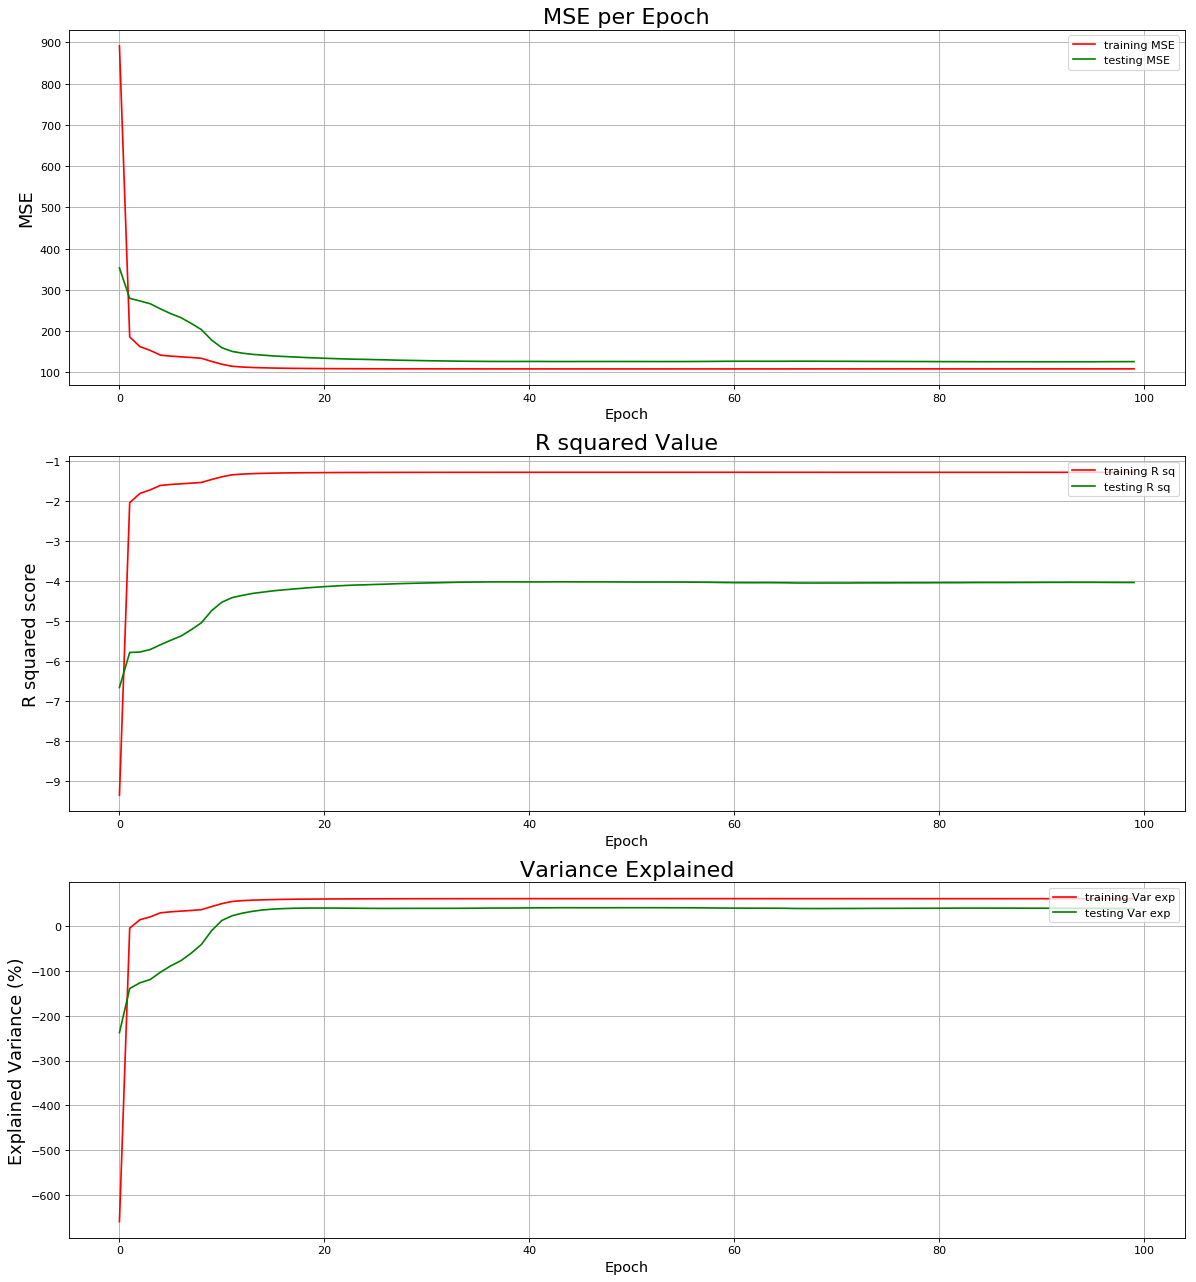

In [16]:
train_loss = np.squeeze(np.mean(np.array(loss_lst_train), axis=1))
test_loss = np.squeeze(np.mean(np.array(loss_lst_test), axis=1))

plt.close()
plt.figure(num=None, figsize=(18, 20), dpi=80)

plt.subplot(311)
plt.title('MSE per Epoch', fontsize=20)
plt.plot( train_loss , 'r')           
plt.plot( test_loss  , 'g')            
# plt.plot( np.array(loss_lst_train) , 'r')            
# plt.plot( np.array(loss_lst_test)  , 'g')
plt.ylabel("MSE", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
# plt.ylim(-0.025,0.225)
plt.legend(['training MSE', 'testing MSE'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title("R squared Value", fontsize=20)
plt.plot(r_sq_lst, 'r')
plt.plot(r_sq_lst_test, 'g')
plt.ylabel("R squared score", fontsize=16)
plt.xlabel("Epoch", fontsize=13)
plt.legend(['training R sq', 'testing R sq'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title("Variance Explained", fontsize=20)
plt.plot(np.array(var_exp_lst) * 100, 'r')
plt.plot(np.array(var_exp_lst_test) * 100, 'g')
plt.ylabel("Explained Variance (%)", fontsize=16)
# plt.ylim(-50,110)
plt.xlabel("Epoch", fontsize=13)
plt.legend(['training Var exp', 'testing Var exp'], loc='upper right')
plt.grid()

# plt.savefig("network_training_loss.png")
plt.show()

### Loading Network weights that have the best testing loss

In [41]:
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v5_network_state_checkpoint80.pth")
# state_dict = model.load_from_checkpoint("/the_good_weights/net1_v3_network_state_checkpoint95.pth")
# state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1/network_state_checkpoint150.pth")  #good
# state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1_lsm2mpu/network_state_checkpoint695.pth")

state_dict = model.load_from_checkpoint("/saved_model_weights/Net1_v3.1_lsm2mpu/network_state_checkpoint35.pth")
model.load_state_dict(state_dict)

Loading model from 
/Users/crohan009/Documents/Stuff/USR18/code base/Sensor_fusion/saved_model_weights/Net1_v3.1_lsm2mpu/network_state_checkpoint35.pth 
...onto the CPU. 



In [42]:
# data_test2 = Network1_Data_loader("Datasets/MPU_rawtoypr_11_cleaned.csv", sequential_test_mode=True)
data_test2 = Network1_Data_loader("Datasets/LSM_rawto_MPUypr_{}_cleaned.csv".format(trial_num), 
                                  sequential_test_mode=True, trans=True)

dsets_enqueuer_trial = torch.utils.data.DataLoader(data_test2, batch_size=1, 
                                                      num_workers=1, drop_last=False)

y_lst = []
o_lst = []
#data_ctr = 0

for idx, data in enumerate(dsets_enqueuer_trial, 1):
        x,y = data['x'], data['y']
        
        #print(x.shape)
        #print(y.shape)
        
        if torch.cuda.is_available():
            x, y = Variable(x.cuda(), requires_grad = False).float(), Variable(y.cuda(), requires_grad = False).float()
        else:
            x, y = Variable(x, requires_grad = False).float(), Variable(y, requires_grad = False).float()

        model.eval()
        output = model(x)
        
        #print(output.shape)
        
        y_lst.append(y)
        o_lst.append(output)
        #data_ctr += 1
        #if data_ctr >= 5000:
        #    break
        
# print("Model output \t= {} \ny \t\t= {}".format(np.squeeze(output.data.numpy()), 
#                                          np.squeeze(y.data.numpy())))
    

In [43]:
# model_output = np.squeeze(np.array(o_lst) )
model_output = np.squeeze(np.array(o_lst))
expected = np.squeeze(np.array(y_lst))

pitch_out, pitch_exp     = model_output[:,0], expected[:,0]
roll_out, roll_exp = model_output[:,1], expected[:,1]
yaw_out, yaw_exp   = model_output[:,2], expected[:,2]

### Visualizing the testing loss 

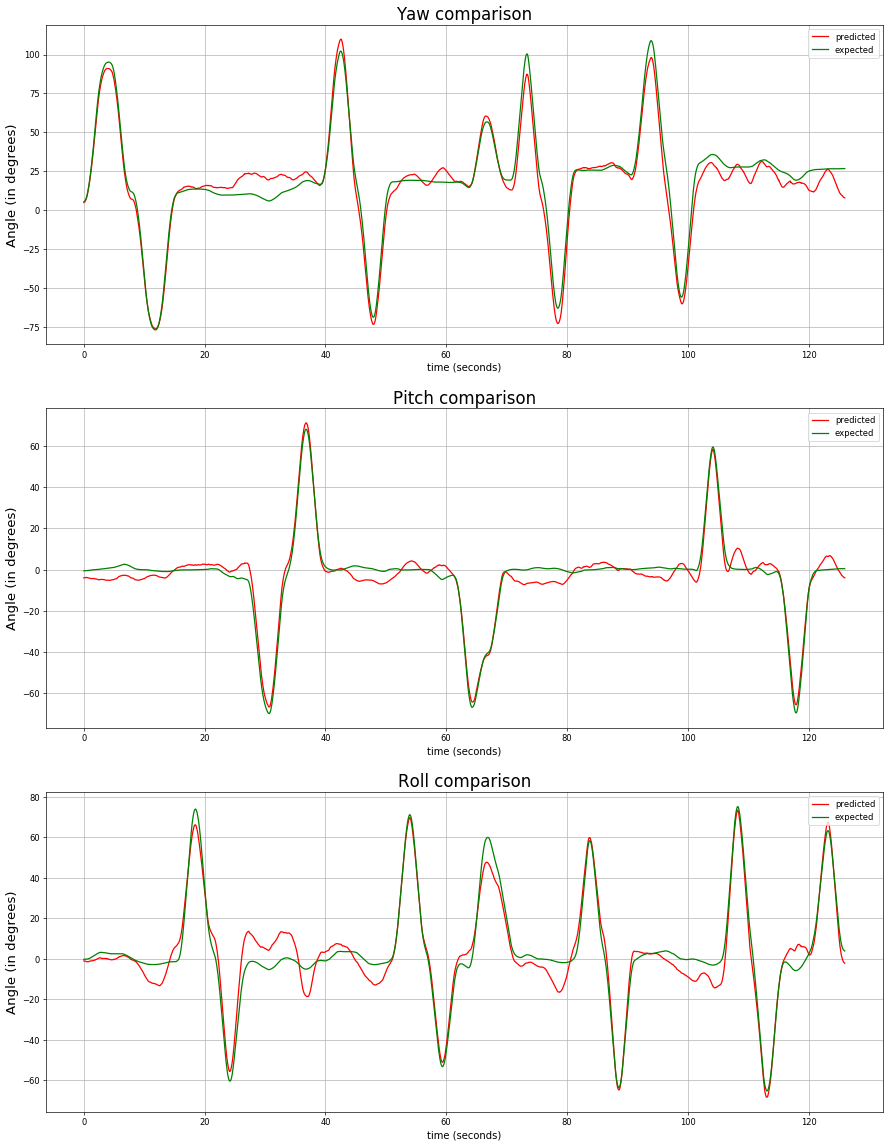

In [55]:
n = len(data_test2) - 99
t = data_test2.runtime
x = list(np.linspace(0, t, n))

plt.close()
plt.figure(num=None, figsize=(18, 24), dpi=60)

plt.subplot(311)
plt.title('Yaw comparison', fontsize=20)
# plt.plot( yaw_out , 'r')            # model output
plt.plot(x, np.convolve(yaw_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( yaw_exp  , 'g')            # expected output
plt.plot(x, np.convolve(yaw_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("time (seconds)", fontsize=12)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(312)
plt.title('Pitch comparison', fontsize=20)
# plt.plot( pitch_out , 'r')            # model output
plt.plot(x, np.convolve(pitch_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( pitch_exp  , 'g')            # expected output
plt.plot(x, np.convolve(pitch_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("time (seconds)", fontsize=12)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.subplot(313)
plt.title('Roll comparison', fontsize=20)
# plt.plot( roll_out , 'r')            # model output
plt.plot(x, np.convolve(roll_out, np.ones((100,))/100, mode='valid'), 'r')      # moving average filtered
# plt.plot( roll_exp  , 'g')            # expected output
plt.plot(x, np.convolve(roll_exp, np.ones((100,))/100, mode='valid'), 'g')      # moving average filtered
plt.ylabel("Angle (in degrees)", fontsize=16)
plt.xlabel("time (seconds)", fontsize=12)
plt.legend(['predicted', 'expected'], loc='upper right')
plt.grid()

plt.savefig("angle_comparison.png")
plt.show()

### Average Yaw, Pitch, Roll Difference (in degrees)

In [45]:
output_yaw = np.convolve(yaw_out, np.ones((100,))/100, mode='valid')
expected_yaw = np.convolve(yaw_exp, np.ones((100,))/100, mode='valid')
distance = 0

for i in range(len(output_yaw)):
    distance = distance + (expected_yaw[i] - output_yaw[i]).abs()

print("Average yaw Difference = ", (distance / len(output_yaw)).data.numpy(), "degrees")

# ----------------------------------------------------------------------------------------------------------------

output_pitch = np.convolve(pitch_out, np.ones((100,))/100, mode='valid')
expected_pitch = np.convolve(pitch_exp, np.ones((100,))/100, mode='valid')
distance = 0

for i in range(len(output_pitch)):
    distance = distance + (expected_pitch[i] - output_pitch[i]).abs()

print("Average pitch Difference = ", (distance / len(output_pitch)).data.numpy(), "degrees")

# ----------------------------------------------------------------------------------------------------------------

output_roll = np.convolve(roll_out, np.ones((100,))/100, mode='valid')
expected_roll = np.convolve(roll_exp, np.ones((100,))/100, mode='valid')
distance = 0

for i in range(len(output_roll)):
    distance = distance + (expected_roll[i] - output_roll[i]).abs()

print("Average roll Difference = ", (distance / len(output_roll)).data.numpy(), "degrees")

Average yaw Difference =  [5.686768] degrees
Average pitch Difference =  [3.4421268] degrees
Average roll Difference =  [5.329122] degrees


In [50]:
print("Average angle difference = ", round(sum([5.686768, 3.4421268, 5.329122])/3, 2), "degrees")

Average angle difference =  4.82 degrees
